# Remarks:
# This code is a copy of COVID tweet sentiment analysis
# It will be used to act as a base for ChatGPT tweet analysis


# Installations


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/UST/BDT/MSBD5001/Project

/content/drive/MyDrive/UST/BDT/MSBD5001/Project


In [ ]:
!pip install --quiet wandb
!pip install --quiet transformers
!pip install --quiet datasets
!pip install --quiet emoji
!pip install --quiet kaggle
!pip install --quiet torchinfo
!pip install --quiet imbalanced-learn
!pip install --quiet gdown
!pip install --quiet clean-text

# my login, hust regirster wanbd account and u'll take trial period which is enough
! wandb login 5f07c28a3cd114f2d72a21eb721a5e7e2da4464f

     |████████████████████████████████| 1.9 MB 28.6 MB/s 
     |████████████████████████████████| 182 kB 28.0 MB/s 
     |████████████████████████████████| 168 kB 57.3 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 168 kB 70.4 MB/s 
     |████████████████████████████████| 166 kB 68.3 MB/s 
     |████████████████████████████████| 166 kB 70.1 MB/s 
     |████████████████████████████████| 162 kB 83.6 MB/s 
     |████████████████████████████████| 162 kB 66.1 MB/s 
     |████████████████████████████████| 158 kB 82.1 MB/s 
     |████████████████████████████████| 157 kB 73.4 MB/s 
     |████████████████████████████████| 157 kB 55.4 MB/s 
     |████████████████████████████████| 157 kB 67.6 MB/s 
     |████████████████████████████████| 157 kB 67.3 MB/s 
     |████████████████████████████████| 157 kB 58.1 MB/s 
     |████████████████████████████████| 157 kB 70.3 MB/s 
     |████████████████████████████████| 157 kB 67.1 MB/s 
     |██████████

In [ ]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Dataset Imports


In [ ]:
import transformers
from torch.utils import data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# data processing
import re, string
import emoji
import nltk

# dataset
from sklearn.model_selection import train_test_split
import datasets
from datasets import Dataset , Sequence , Value , Features , ClassLabel , DatasetDict

# preprocessing
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

import re, string

from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# list of pretrained models: https://huggingface.co/transformers/v3.3.1/pretrained_models.html
models = ["distilbert-base-uncased", "bert-base-uncased", "bert-base-cased"]
modelName = models[2] 

# Dataset Review Functions for
datatattle/covid-19-nlp-text-classification

In [ ]:
df_train = pd.read_csv("Corona_NLP_train.csv", encoding='latin-1')
print(df_train.shape)
print(df_train.columns)

(41157, 6)
Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')


In [ ]:
df_train = df_train[["OriginalTweet", "Sentiment"]]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [ ]:
df_train.drop_duplicates(subset='OriginalTweet',inplace=True)
df_train = df_train.rename({'OriginalTweet': 'Reviews'}, axis='columns')
df_train['Sentiment']=df_train['Sentiment'].replace({'Neutral':2, 'Positive':3,'Extremely Positive':4, 'Extremely Negative':0,'Negative':1})
df_train['Sentiment']=df_train['Sentiment'].astype(int)

df_train = df_train.reset_index(drop=True)
df_train.head()

,Reviews,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,3
2,Coronavirus Australia: Woolworths to give elde...,3
3,My food stock is not the only one which is emp...,3
4,"Me, ready to go at supermarket during the #COV...",0


In [ ]:
# df.info()
df_train.isnull().sum()

Reviews      0
Sentiment    0
dtype: int64

In [ ]:
df_train["Sentiment"].value_counts()

3    11422
1     9917
2     7713
4     6624
0     5481
Name: Sentiment, dtype: int64

In [ ]:
# word tokenizer
df_train['Reviews_len_by_words'] = df_train['Reviews'].apply(lambda t: len(t.split()))
min_len_word, max_len_word = df_train['Reviews_len_by_words'].min(), df_train['Reviews_len_by_words'].max()
print(min_len_word, max_len_word)

1 64


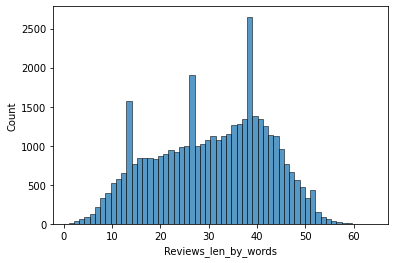

In [ ]:
sns.histplot(df_train['Reviews_len_by_words'])

# padding is based on the token lengths not the word lengths > MAX_LEN=64

In [ ]:
df_train.describe()

,Sentiment,Reviews_len_by_words
count,41157.000000,41157.000000
mean,2.092111,30.500304
std,1.298655,11.591172
min,0.000000,1.000000
25%,1.000000,21.000000
50%,2.000000,32.000000
75%,3.000000,40.000000
max,4.000000,64.000000


[Text(0, 0, 'Extremely Negative'),
 Text(0, 0, 'Negative'),
 Text(0, 0, 'Neutral'),
 Text(0, 0, 'Positive'),
 Text(0, 0, 'Extremely Positive')]

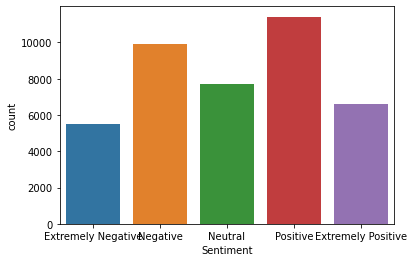

In [ ]:
class_names = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
ax = sns.countplot(x='Sentiment', data=df_train)
ax.set_xticklabels(class_names)

In [ ]:
df_test = pd.read_csv("Corona_NLP_test.csv",encoding='latin')
df_test = df_test.drop(labels=['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1)
df_test.drop_duplicates(subset='OriginalTweet',inplace=True)

df_test = df_test.rename({'OriginalTweet': 'Reviews'}, axis="columns")

df_test['Sentiment']=df_test['Sentiment'].replace({'Neutral':2, 'Positive':3,'Extremely Positive':4, 'Extremely Negative':0,'Negative':1})
df_test['Sentiment']=df_test['Sentiment'].astype(int)
df_test = df_test.reset_index(drop=True)

df_test.head()

,Reviews,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,0
1,When I couldn't find hand sanitizer at Fred Me...,3
2,Find out how you can protect yourself and love...,4
3,#Panic buying hits #NewYork City as anxious sh...,1
4,#toiletpaper #dunnypaper #coronavirus #coronav...,2


In [ ]:
# suffle series
# df_train = df_train.sample(frac=1, random_state=RANDOM_SEED)

print(df_train.shape , df_test.shape)
df_train, df_val = train_test_split(df_train, test_size=0.09, random_state=RANDOM_SEED, stratify=df_train['Sentiment'])
print(df_train.shape , df_val.shape, df_test.shape)

(41157, 3) (3798, 2)
(37452, 3) (3705, 3) (3798, 2)


In [ ]:
def createDataset(df, textCol, labelCol):
  dataset_dict = {
    'text' : df[textCol],
    'labels' : df[labelCol],
  }
  sent_tags = ClassLabel(num_classes=5 , names=['Extremely Negative', 'Negative','Neutral','Positive', 'Extremely Positive'])

  return Dataset.from_dict(
    mapping = dataset_dict,
    features = Features({'text' : Value(dtype='string') , 'labels' :sent_tags})
  )

In [ ]:
dataset_train = createDataset(df_train,"Reviews","Sentiment")
dataset_val = createDataset(df_val,"Reviews","Sentiment")
dataset_test = createDataset(df_test,"Reviews","Sentiment")

dataset_sentAnalysis = DatasetDict()
dataset_sentAnalysis["train"] = dataset_train
dataset_sentAnalysis["val"] = dataset_val
dataset_sentAnalysis["test"] = dataset_test

dataset_sentAnalysis

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 37452
    })
    val: Dataset({
        features: ['text', 'labels'],
        num_rows: 3705
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 3798
    })
})

# Data Preprocessing

In [ ]:
def convert_to_lower(text):
    return text.lower()

def remove_emojis(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r"<.*?>","",text)

    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    return wierd_pattern.sub(r'', text)

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def preprocessText(text):
  return remove_extra_white_spaces(remove_stopwords(remove_punctuation(remove_numbers(remove_emojis(convert_to_lower(text))))))

def preprocessBatch(batch):
  new_list = []
  for i in batch["text"]:
    new_list.append(remove_extra_white_spaces(remove_stopwords(remove_punctuation(remove_numbers(remove_emojis(convert_to_lower(i)))))))
  batch["text"] = new_list
  return batch

In [ ]:
# After preprocessing
temp = df_train['Reviews'].apply(preprocessText).apply(lambda t: len(t.split()))
min_len_word, max_len_word = temp.min(), temp.max()
print(min_len_word, max_len_word)

0 44


ValueError: ignored

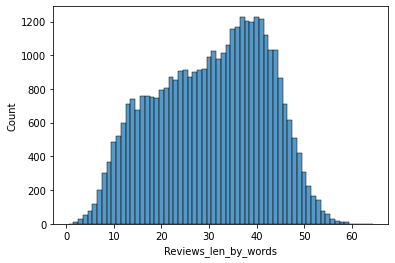

In [ ]:
sns.histplot(data=df_train['Reviews_len_by_words'], discrete=True)

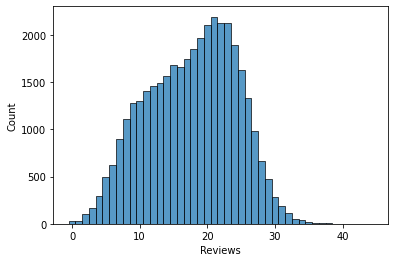

In [ ]:
sns.histplot(temp, discrete=True)

In [ ]:
dataset_sentAnalysis_preprocessed = dataset_sentAnalysis.map(preprocessBatch, batched=True, batch_size=32)

  0%|          | 0/1171 [00:00<?, ?ba/s]

  0%|          | 0/116 [00:00<?, ?ba/s]

  0%|          | 0/119 [00:00<?, ?ba/s]

In [ ]:
dataset_sentAnalysis["train"][10]

{'text': "NYC Administrative Code 20-701(b) makes it illegal to increase prices by 10 percent or more during a 60 day period. If you've witnessed #PriceGouging on items like #HandSanitizer during the #coronavirus, you can report it the Attorney General. Learn how: https://t.co/Qjl8iWnkIk https://t.co/1XoKevtQ5U",
 'labels': 3}

In [ ]:
dataset_sentAnalysis_preprocessed["train"][10]

{'text': 'nyc administrative code makes illegal increase prices percent day period youve witnessed pricegouging items like handsanitizer coronavirus report attorney general learn',
 'labels': 3}

# Tokenizer


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(modelName)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
max_len = 128
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=max_len)

In [ ]:
sample_text = "What is  going on @resturant.:( It makes   Me Feel Upset.😞"
tokens = tokenizer.tokenize(sample_text)
print(len(tokens), tokens)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(len(token_ids), token_ids)

token_dictionary = tokenizer(sample_text)
print(token_dictionary)
print(len(token_dictionary.input_ids)) # automatically added cls, sep

tokens = tokenizer.convert_ids_to_tokens(token_dictionary['input_ids'])
print(tokens)

token_encode = tokenizer.encode(sample_text) #convert to tokens ids but with cls+sep
print(token_encode)

19 ['What', 'is', 'going', 'on', '@', 'rest', '##ura', '##nt', '.', ':', '(', 'It', 'makes', 'Me', 'Feel', 'Up', '##set', '.', '[UNK]']
19 [1327, 1110, 1280, 1113, 137, 1832, 4084, 2227, 119, 131, 113, 1135, 2228, 2508, 14425, 3725, 9388, 119, 100]
{'input_ids': [101, 1327, 1110, 1280, 1113, 137, 1832, 4084, 2227, 119, 131, 113, 1135, 2228, 2508, 14425, 3725, 9388, 119, 100, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
21
['[CLS]', 'What', 'is', 'going', 'on', '@', 'rest', '##ura', '##nt', '.', ':', '(', 'It', 'makes', 'Me', 'Feel', 'Up', '##set', '.', '[UNK]', '[SEP]']
[101, 1327, 1110, 1280, 1113, 137, 1832, 4084, 2227, 119, 131, 113, 1135, 2228, 2508, 14425, 3725, 9388, 119, 100, 102]


In [ ]:
# we use special tokens to separate the sentences. How bert works
print(tokenizer)
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

PreTrainedTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
# the inputs same as distilbert_tokenizer()
encoding = tokenizer.encode_plus(
    sample_text,
    max_length=max_len,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors="pt"
)
encoding

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'input_ids': tensor([[  101,  1327,  1110,  1280,  1113,   137,  1832,  4084,  2227,   119,
           131,   113,  1135,  2228,  2508, 14425,  3725,  9388,   119,   100,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [ ]:
dataset_sentAnalysis_encoded = dataset_sentAnalysis_preprocessed.map(tokenize, batched=True, batch_size=32)

  0%|          | 0/1171 [00:00<?, ?ba/s]

  0%|          | 0/116 [00:00<?, ?ba/s]

  0%|          | 0/119 [00:00<?, ?ba/s]

In [ ]:
dataset_sentAnalysis_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 37452
    })
    val: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3705
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3798
    })
})

# Add Classification head manually for Model


In [ ]:
from transformers import BertConfig
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class BertForClassification(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        # Load model body > return all og the HS
        self.bert = BertModel(config)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()


    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.bert(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)

        # Apply classifier to encoder representation > [cls]
        sequence_output = self.dropout(outputs[1])
        logits = self.classifier(sequence_output)

        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
from transformers import AutoConfig

id2label = {
    0: 'Extremely Negative',
    1: 'Negative',
    2: 'Neutral',
    3: 'Positive',
    4: 'Extremely Positive'
}

label2id = { v:k for (k,v) in id2label.items()}

bert_config = AutoConfig.from_pretrained(modelName, 
                                         num_labels=5,
                                         id2label=id2label, label2id=label2id)

In [ ]:
bert_model = (BertForClassification
              .from_pretrained(modelName, config=bert_config)
              .to(device))

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForClassification were not initialized from the model checkpoint at bert-base-cased and are newly ini

# Training Arguments

In [ ]:
from transformers import Trainer, TrainingArguments
import wandb
wandb.login()

wandb.init(project="bert-for-english-classification")


batch_size = 16
logging_steps = len(dataset_sentAnalysis_encoded["train"]) // batch_size
model_name = f"{modelName}-finetuned-sentimentAnalysis-bert"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch", 
                                  save_steps=1e6,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error",
                                  report_to="wandb",
                                  run_name="bert-sent-analysis")

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(bert_model.parameters(), lr=2e-5)

num_epochs = 10
num_training_steps = num_epochs * logging_steps
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

trainer_preprocessed_lr = Trainer(model=bert_model, args=training_args,
                                  compute_metrics=compute_metrics,
                                  train_dataset=dataset_sentAnalysis_encoded["train"],
                                  eval_dataset=dataset_sentAnalysis_encoded["val"],
                                  tokenizer=tokenizer,
                                  optimizers=(optimizer,lr_scheduler))

trainer_preprocessed_lr.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.876400,0.713917,0.736302,0.735905
2,0.592700,0.678581,0.756005,0.755801
3,0.456800,0.662979,0.772470,0.773875
4,0.359400,0.735247,0.777868,0.778264
5,0.279000,0.962503,0.769501,0.769768


TrainOutput(global_step=11705, training_loss=0.5127714675188777, metrics={'train_runtime': 2841.1034, 'train_samples_per_second': 65.911, 'train_steps_per_second': 4.12, 'total_flos': 7100569916458632.0, 'train_loss': 0.5127714675188777, 'epoch': 5.0})

# Evaluation



In [ ]:
model = bert_model
model.eval()
preds_output = trainer_preprocessed_lr.predict(dataset_sentAnalysis_encoded["test"])
pd.DataFrame(list(preds_output.metrics.items())).T

,0,1,2,3,4,5
0,test_loss,test_accuracy,test_f1,test_runtime,test_samples_per_second,test_steps_per_second
1,1.026923,0.740653,0.74094,12.2155,310.917,19.483


In [ ]:
PATH = "./bert-classification-classification-head"
# torch.save(bert_model.state_dict(), PATH)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

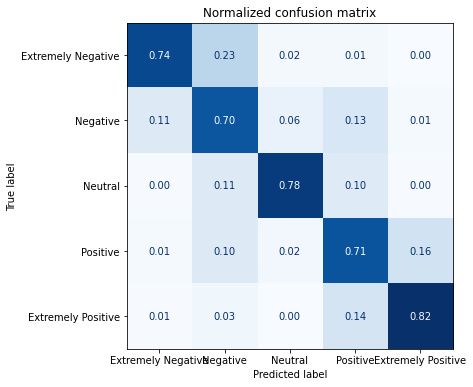

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_test = np.array(dataset_sentAnalysis_encoded["test"]["labels"])
labels = dataset_sentAnalysis_encoded["train"].features["labels"].names
plot_confusion_matrix(y_preds, y_test, labels)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['Extremely Negative', 'Negative','Neutral', 'Positive', 'Extremely Positive']
print(classification_report(y_test, y_preds, target_names=class_names))

                    precision    recall  f1-score   support

Extremely Negative       0.77      0.74      0.76       592
          Negative       0.69      0.70      0.70      1041
           Neutral       0.85      0.78      0.81       619
          Positive       0.70      0.71      0.70       947
Extremely Positive       0.75      0.82      0.78       599

          accuracy                           0.74      3798
         macro avg       0.75      0.75      0.75      3798
      weighted avg       0.74      0.74      0.74      3798



# Predict one input

In [ ]:
# from transformers import BertForSequenceClassification
# loaded_model = BertForSequenceClassification.from_pretrained(
#     modelName,
#     num_labels=5,
#     id2label=id2label,
#     label2id=label2id
# ).to(device)

# loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself

# loaded_model.eval()

In [ ]:
import numpy as np
import torch.nn.functional as F

def predict_text(model,text):
  inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=max_len)
  inputs = {k:v.to(device) for k,v in inputs.items()}
  with torch.no_grad():
    outputs = model(**inputs)
  out = F.softmax(outputs.logits,dim=1)
  y_out = np.argmax(out.cpu(),axis=1)
  return out, y_out

In [ ]:
sample_text = "I know there are certain cases where people can be harsh but i stay depressed because of it"
out, y_out = predict_text(model,sample_text)
out, id2label[y_out.item()]

(tensor([[9.8355e-01, 1.1636e-02, 1.3936e-03, 2.7753e-03, 6.4496e-04]],
        device='cuda:0'), 'Extremely Negative')

In [ ]:
pd.set_option('display.max_colwidth', -1)
pd.DataFrame({
    "Text": sample_text,
    "Sentiment": class_names[y_out.item()]
},index=[0]).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,0
Text,I know there are certain cases where people can be harsh but i stay depressed because of it
Sentiment,Extremely Negative


# Predict on 5 countries

In [ ]:
%cd dataset

/content/drive/MyDrive/UST/BDT/MSBD5001/Project/dataset


In [ ]:
def read_preproces_tweet_tsv(filename: str):
  df = pd.read_csv(filename, sep='\t')
  df = df[['date', 'country_code', 'Original_Tweet']]
  df = df[~df['Original_Tweet'].isnull()]
  df = df.sort_values(by=['date'])
  print(df.shape)
  return df

In [ ]:
def pred_all(texts: list):
  preds = []
  for text in texts:
    out, y_out = predict_text(model, text)
    preds.append(y_out.item())
  return preds

In [ ]:
df_all_US = read_preproces_tweet_tsv('all_US_tweet.tsv')
df_all_GB = read_preproces_tweet_tsv('all_GB_tweet.tsv')
df_all_IN = read_preproces_tweet_tsv('all_IN_tweet.tsv')
df_all_CA = read_preproces_tweet_tsv('all_CA_tweet.tsv')
df_all_AU = read_preproces_tweet_tsv('all_AU_tweet.tsv')

In [ ]:
df_all_US['Sentiment'] = pred_all(df_all_US['Original_Tweet'].apply(preprocessText))

In [ ]:
df_all_US['Preprocessed'] = df_all_US['Original_Tweet'].apply(preprocessText)

In [ ]:
pd.set_option('max_colwidth', 400)
df_all_US

,date,country_code,Original_Tweet,Preprocessed
0,2020-07-26,US,picture your 8 year old with a rifle gun helmet and cigarette waiting for the enemy.\n\n#thankyouholyspirit #SpeakingOut #Science #COVID19 #kids #findmaryj #fearwomen #twitch #bubonicplague #alcoholinkart #acim,picture year old rifle gun helmet cigarette waiting enemy thankyouholyspirit speakingout science covid kids findmaryj fearwomen twitch bubonicplague alcoholinkart acim
1,2020-07-26,US,Do you think congress should voluntarily take a reduction in their pay until this coronavirus pandemic is over?,think congress voluntarily take reduction pay coronavirus pandemic
2,2020-07-26,US,Florida SBDC at @FIUBusiness helps local small businesses obtain $31.25 million in COVID-19 aid\n\n.@FIUalumni @FIUBusinessAlum \n\n#PawsUp \n\nhttps://t.co/XVMOH6Y9i1,florida sbdc helps local small businesses obtain million covid aid pawsup
5,2020-07-26,US,"@realDonaldTrump @POTUS @Yankees FYI: as soon as I see you don’t use the term COVID-19 but rather your racist term, I stop reading your Tweet.",fyi soon see ’ use term covid rather racist term stop reading tweet
17,2020-07-27,US,Big shoutout to Kyrie though,big shoutout kyrie though
...,...,...,...,...
8152,2022-11-17,US,"With so much going on and parents keeping their children out of school for safety precautions against #COVID19, we know these families are a target of @ACSNYC due to school mandated reporting! So we are going to continue to educate our parents &amp; families of their rights! https://t.co/4CBWKU6caG",much going parents keeping children school safety precautions covid know families target due school mandated reporting going continue educate parents amp families rights
8157,2022-11-17,US,👀\nwaiting for the Tefillin-Covid Testing booth to arrive\n#Challah ✡️ #COVID19 https://t.co/aU6C2iocC7,waiting tefillincovid testing booth arrive challah covid
8151,2022-11-18,US,This shit is despotic.,shit despotic
8153,2022-11-18,US,@the_moviebob There is this... \n\nhttps://t.co/KrDFqfe8E1,


In [ ]:
df_all_US

,date,country_code,Original_Tweet,Sentiment
0,2020-07-26,US,picture your 8 year old with a rifle gun helmet and cigarette waiting for the enemy.\n\n#thankyouholyspirit #SpeakingOut #Science #COVID19 #kids #findmaryj #fearwomen #twitch #bubonicplague #alcoholinkart #acim,0
1,2020-07-26,US,Do you think congress should voluntarily take a reduction in their pay until this coronavirus pandemic is over?,1
2,2020-07-26,US,Florida SBDC at @FIUBusiness helps local small businesses obtain $31.25 million in COVID-19 aid\n\n.@FIUalumni @FIUBusinessAlum \n\n#PawsUp \n\nhttps://t.co/XVMOH6Y9i1,3
5,2020-07-26,US,"@realDonaldTrump @POTUS @Yankees FYI: as soon as I see you don’t use the term COVID-19 but rather your racist term, I stop reading your Tweet.",1
17,2020-07-27,US,Big shoutout to Kyrie though,2
...,...,...,...,...
8152,2022-11-17,US,"With so much going on and parents keeping their children out of school for safety precautions against #COVID19, we know these families are a target of @ACSNYC due to school mandated reporting! So we are going to continue to educate our parents &amp; families of their rights! https://t.co/4CBWKU6caG",3
8157,2022-11-17,US,👀\nwaiting for the Tefillin-Covid Testing booth to arrive\n#Challah ✡️ #COVID19 https://t.co/aU6C2iocC7,2
8151,2022-11-18,US,This shit is despotic.,1
8153,2022-11-18,US,@the_moviebob There is this... \n\nhttps://t.co/KrDFqfe8E1,2


In [ ]:
df_all_GB['Sentiment'] = pred_all(df_all_GB['Original_Tweet'].apply(preprocessText))

In [ ]:
df_all_IN['Sentiment'] = pred_all(df_all_IN['Original_Tweet'].apply(preprocessText))

In [ ]:
df_all_CA['Sentiment'] = pred_all(df_all_CA['Original_Tweet'].apply(preprocessText))

In [ ]:
df_all_AU['Sentiment'] = pred_all(df_all_AU['Original_Tweet'].apply(preprocessText))

In [ ]:
df_all_US.to_csv('all_US_tweet_sentiment.tsv', sep='\t')
df_all_GB.to_csv('all_GB_tweet_sentiment.tsv', sep='\t')
df_all_IN.to_csv('all_IN_tweet_sentiment.tsv', sep='\t')
df_all_CA.to_csv('all_CA_tweet_sentiment.tsv', sep='\t')
df_all_AU.to_csv('all_AU_tweet_sentiment.tsv', sep='\t')

# Visualization

In [ ]:
df_all = pd.read_csv('all.tsv', sep='\t')
df_all_US = pd.read_csv('all_US_tweet_sentiment.tsv', sep='\t')
df_all_GB = pd.read_csv('all_GB_tweet_sentiment.tsv', sep='\t')
df_all_IN = pd.read_csv('all_IN_tweet_sentiment.tsv', sep='\t')
df_all_CA = pd.read_csv('all_CA_tweet_sentiment.tsv', sep='\t')
df_all_AU = pd.read_csv('all_AU_tweet_sentiment.tsv', sep='\t')

In [ ]:
def sum_every_n(l: list, n: int):
  lr = []
  while len(l) > n:
    lr.append(np.mean(l[:n]))
    l = l[n:]
  else:
    lr.append(np.mean(l))
  return lr

In [ ]:
df_all_date = df_all['date']
df_all_US_date = df_all[df_all['country_code'] == 'US']['date']
df_all_GB_date = df_all[df_all['country_code'] == 'GB']['date']
df_all_IN_date = df_all[df_all['country_code'] == 'IN']['date']
df_all_CA_date = df_all[df_all['country_code'] == 'CA']['date']
df_all_AU_date = df_all[df_all['country_code'] == 'AU']['date']

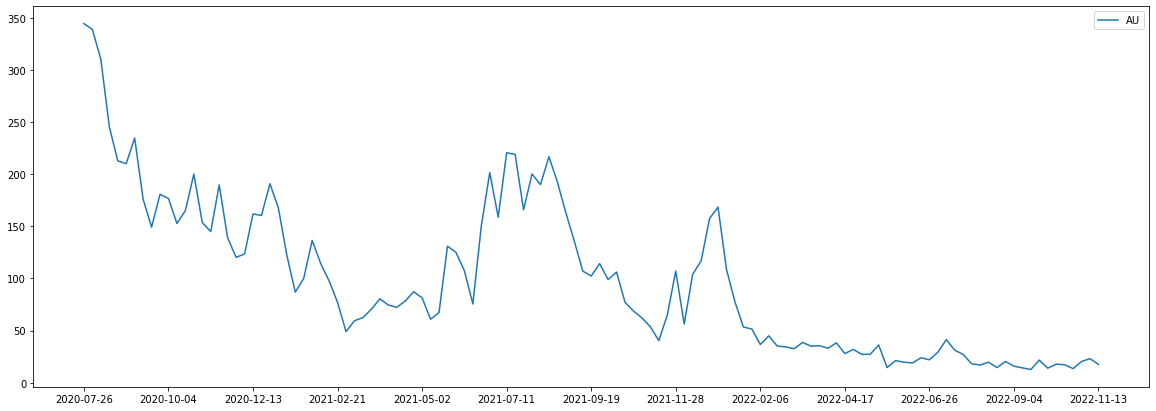

In [ ]:
import matplotlib.pyplot as plt
import datetime
from datetime import date, timedelta

sample = 7

dates = []
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2020, 7, 26)
end_date = date(2022, 11, 18)
xticks = []
count = 0
for single_date in daterange(start_date, end_date):
  if (count % sample) == 0:
    dates.append(single_date.strftime("%Y-%m-%d"))
  if (count % 70) == 0:
    xticks.append(single_date.strftime("%Y-%m-%d"))
  count += 1

plt.figure(figsize=(20, 7))

# plt.plot(dates, sum_every_n(list(df_all_date.value_counts().sort_index()), sample), label='number of tweet per day')
# plt.plot(dates, sum_every_n(list(df_all_US_date.value_counts().sort_index()), sample), label='US')
# plt.plot(dates, sum_every_n(list(df_all_GB_date.value_counts().sort_index()), sample), label='GB')
# plt.plot(dates, sum_every_n(list(df_all_IN_date.value_counts().sort_index()), sample), label='IN')
# plt.plot(dates, sum_every_n(list(df_all_CA_date.value_counts().sort_index()), sample), label='CA')
plt.plot(dates, sum_every_n(list(df_all_AU_date.value_counts().sort_index()), sample), label='AU')
plt.xticks(xticks)

plt.legend(loc='upper right')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import datetime
from datetime import date, timedelta

sample = 7

dates = []
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2020, 7, 26)
end_date = date(2022, 11, 18)
xticks = []
count = 0
for single_date in daterange(start_date, end_date):
  if (count % sample) == 0:
    dates.append(single_date.strftime("%Y-%m-%d"))
  if (count % 70) == 0:
    xticks.append(single_date.strftime("%Y-%m-%d"))
  count += 1

plt.figure(figsize=(20, 7))

plt.plot(dates, sum_every_n(list(df_all_date.value_counts().sort_index()), sample), label='number of tweet per day')
# plt.plot(df_all_date.value_counts().sort_index())
plt.xticks(xticks)

plt.legend(loc='upper right')
plt.show()

In [ ]:
US_list = list(df_all_US[['date', 'Sentiment']].groupby(['date']).agg('mean')['Sentiment'])
GB_list = list(df_all_GB[['date', 'Sentiment']].groupby(['date']).agg('mean')['Sentiment'])
IN_list = list(df_all_IN[['date', 'Sentiment']].groupby(['date']).agg('mean')['Sentiment'])
CA_list = list(df_all_CA[['date', 'Sentiment']].groupby(['date']).agg('mean')['Sentiment'])
AU_list = list(df_all_AU[['date', 'Sentiment']].groupby(['date']).agg('mean')['Sentiment'])

In [ ]:
temp = pd.concat([df_all_US[['date', 'Sentiment']], df_all_GB[['date', 'Sentiment']]],axis=0)
temp = pd.concat([temp, df_all_IN[['date', 'Sentiment']]],axis=0)
temp = pd.concat([temp, df_all_CA[['date', 'Sentiment']]],axis=0)
temp = pd.concat([temp, df_all_AU[['date', 'Sentiment']]],axis=0)
all_list = list(temp.groupby(['date']).agg('mean')['Sentiment'])

[Text(0, 0, 'Extremely Negative'),
 Text(0, 0, 'Negative'),
 Text(0, 0, 'Neutral'),
 Text(0, 0, 'Positive'),
 Text(0, 0, 'Extremely Positive')]

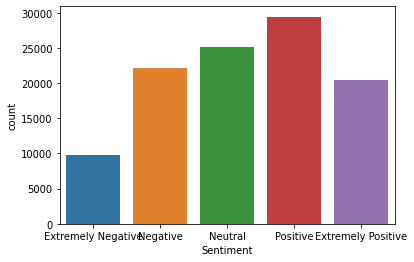

In [ ]:
class_names = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
temp = pd.concat([df_all_AU, pd.concat([df_all_CA, pd.concat([df_all_IN, pd.concat([df_all_US, df_all_GB],axis=0)],axis=0)],axis=0)],axis=0)
ax = sns.countplot(x='Sentiment', data=pd.concat([temp, pd.concat([temp, temp], axis=0)], axis=0))
ax.set_xticklabels(class_names)

In [ ]:
[np.mean([a,b,c,d,e]) for a, b, c, d, e in zip(US_list, GB_list, IN_list, CA_list, AU_list)]

[1.6154761904761905,
 2.408333333333333,
 1.9149999999999998,
 2.477777777777778,
 2.208333333333333,
 2.300865800865801,
 2.496212121212121,
 2.3114285714285714,
 2.096904761904762,
 2.3496031746031747,
 1.9327777777777775,
 2.0380952380952384,
 2.2477272727272726,
 1.993968253968254,
 2.5436147186147187,
 2.1384920634920634,
 2.4531746031746033,
 2.230793650793651,
 2.1612698412698412,
 2.503333333333333,
 2.2169841269841273,
 2.1468253968253967,
 2.177777777777778,
 2.5464285714285717,
 2.0885714285714285,
 2.4194444444444447,
 2.2373015873015873,
 2.3916666666666666,
 2.4686507936507938,
 2.5277777777777777,
 2.314044289044289,
 2.6337301587301587,
 2.5523809523809526,
 2.134920634920635,
 2.0254545454545454,
 2.2756349206349205,
 2.435714285714286,
 2.586666666666667,
 2.246303696303696,
 2.15,
 2.127619047619048,
 2.1496103896103897,
 2.1196825396825396,
 2.0936507936507938,
 2.2984126984126982,
 2.1833333333333336,
 2.2966666666666664,
 2.1095238095238096,
 2.1,
 2.1173015873015

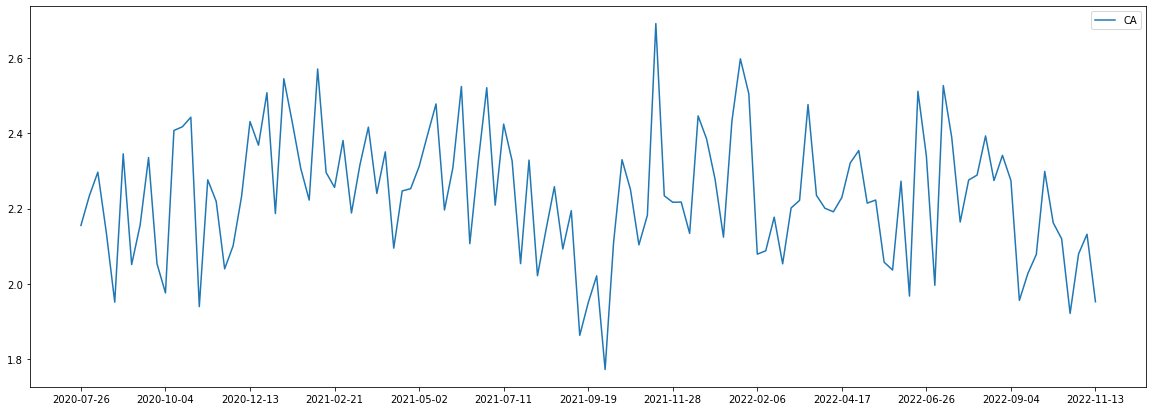

In [ ]:
import matplotlib.pyplot as plt
import datetime
from datetime import date, timedelta

sample = 14

dates = []
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2020, 7, 26)
end_date = date(2022, 11, 18)
xticks = []
count = 0
for single_date in daterange(start_date, end_date):
  if (count % sample) == 0:
    dates.append(single_date.strftime("%Y-%m-%d"))
  if (count % 70) == 0:
    xticks.append(single_date.strftime("%Y-%m-%d"))
  count += 1

plt.figure(figsize=(20, 7))

# plt.plot(dates, sum_every_n(list(df_all_US[['date', 'Sentiment']].groupby(['date']).agg('mean')['Sentiment']), sample), label='US')
# plt.plot(dates, sum_every_n(list(df_all_GB[['date', 'Sentiment']].groupby(['date']).agg('mean')['Sentiment']), sample), label='GB')
# plt.plot(dates, sum_every_n(list(df_all_IN[['date', 'Sentiment']].groupby(['date']).agg('mean')['Sentiment']), sample), label='IN')
plt.plot(dates, sum_every_n(list(df_all_CA[['date', 'Sentiment']].groupby(['date']).agg('mean')['Sentiment']), sample), label='CA')
# plt.plot(dates, sum_every_n(list(df_all_AU[['date', 'Sentiment']].groupby(['date']).agg('mean')['Sentiment']), sample), label='AU')
# plt.plot(dates, sum_every_n(all_list, sample))

plt.xticks(xticks)

plt.legend(loc='upper right')
plt.show()

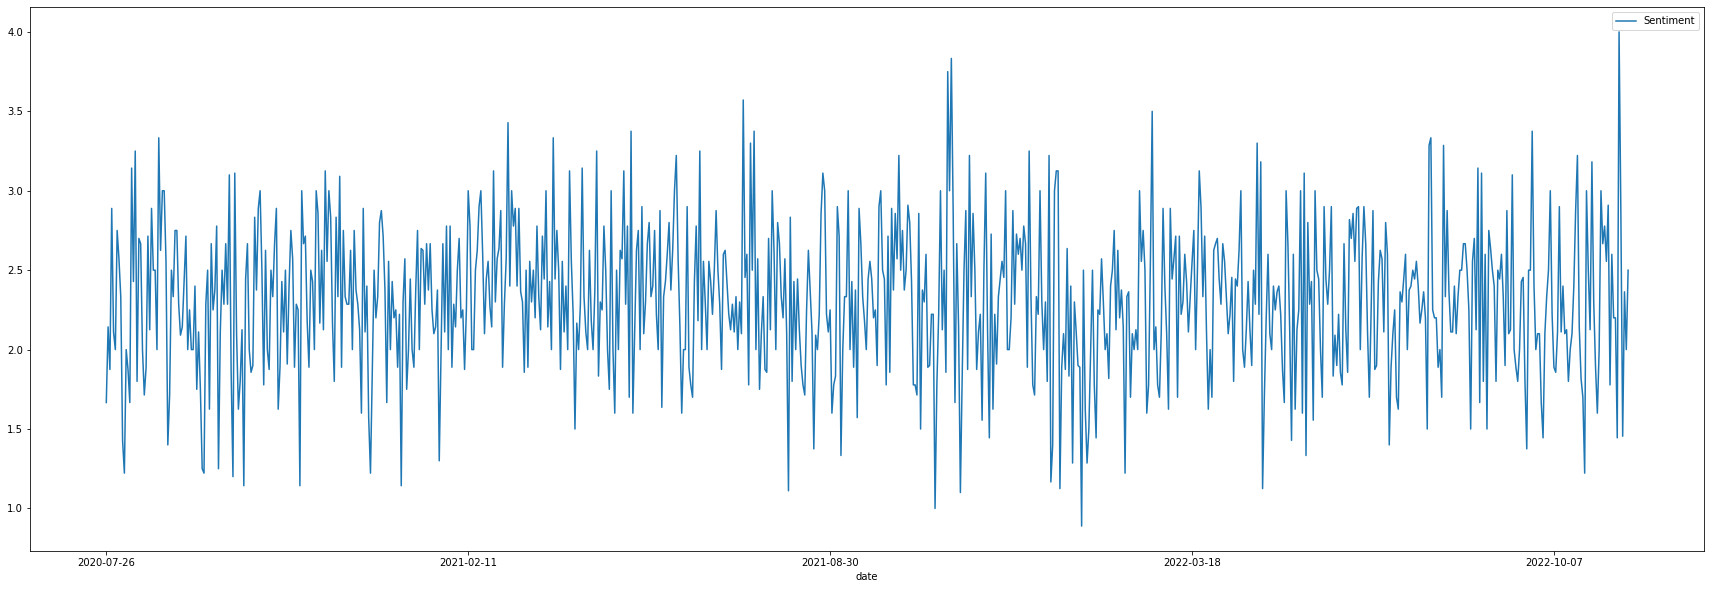

In [ ]:
df_all_GB[['date', 'Sentiment']].groupby(['date']).agg('mean').plot(figsize=(30, 10))

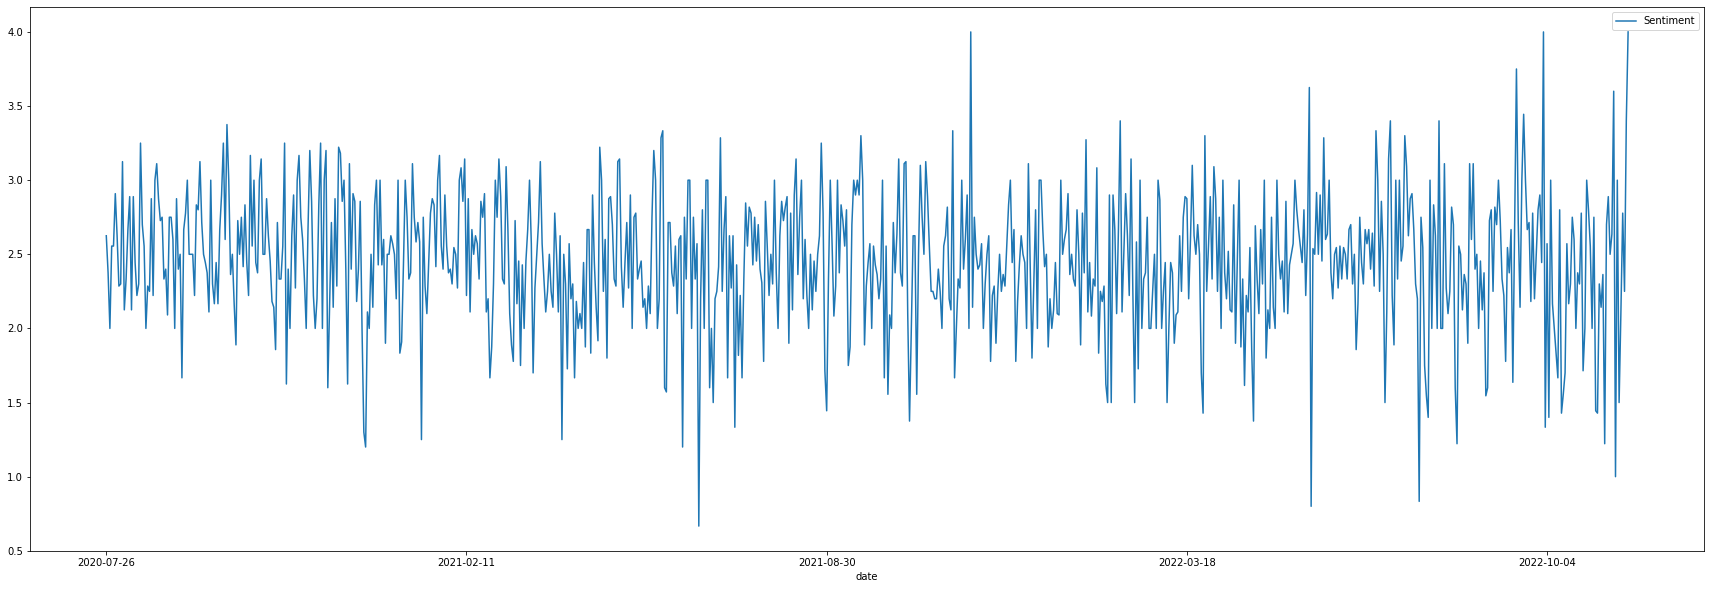

In [ ]:
df_all_IN[['date', 'Sentiment']].groupby(['date']).agg('mean').plot(figsize=(30, 10))

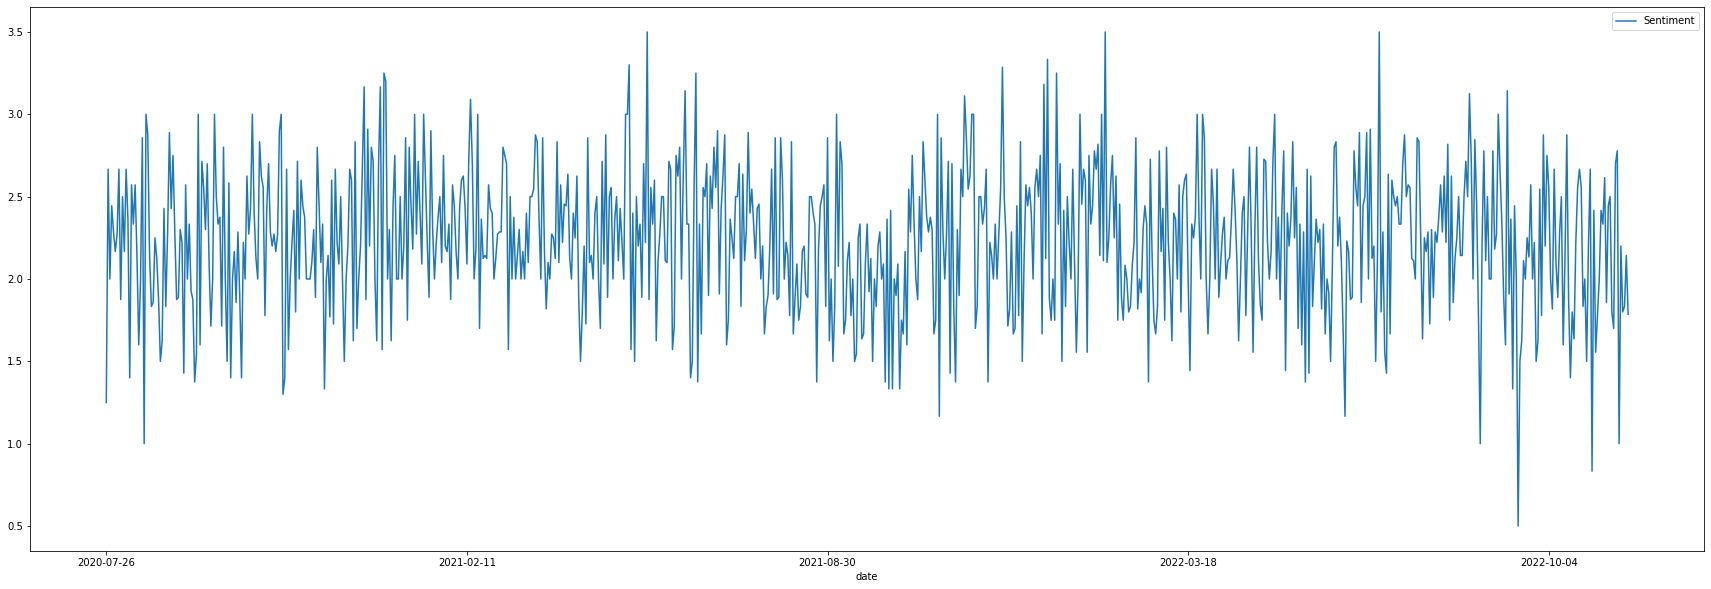

In [ ]:
df_all_CA[['date', 'Sentiment']].groupby(['date']).agg('mean').plot(figsize=(30, 10))

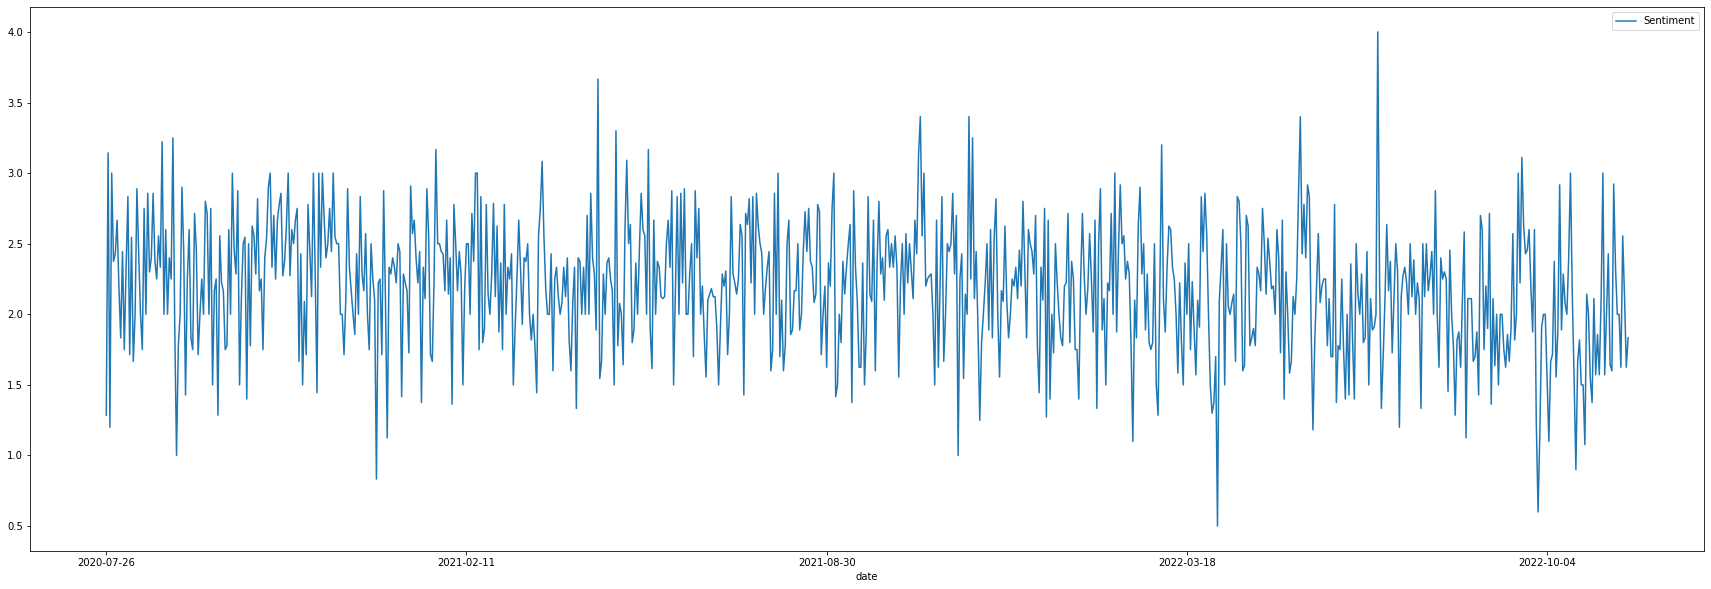

In [ ]:
df_all_AU[['date', 'Sentiment']].groupby(['date']).agg('mean').plot(figsize=(30, 10))